In [2]:
cd d:\0python\phm\phm2017

d:\0python\phm\phm2017


In [3]:
ls

 驱动器 D 中的卷是 DATA
 卷的序列号是 561E-75BB

 d:\0python\phm\phm2017 的目录

2018/04/26  22:26    <DIR>          .
2018/04/26  22:26    <DIR>          ..
2018/04/22  07:48             8,341 conInterval.py
2018/04/26  22:26            13,080 predictFaultyRegimes.py
2018/04/22  08:07           109,017 regression_wLegend.png
2017/05/19  21:41               117 Sample-Predictions.csv
2018/04/17  08:16    <DIR>          testing
2017/05/20  22:14             3,688 testing.csv
2018/04/17  08:16    <DIR>          training
2017/05/20  22:09             4,864 training.csv
               6 个文件        139,107 字节
               4 个目录 112,537,137,152 可用字节


## 导入包 定义函数

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

In [199]:
# 特征处理
def fetProcess(Arr):
    outArr = np.zeros(155)
    posArr = []
    for i in range(5):
        outArr[0 + i] = Arr[0 + i] / Arr[5 + i]; posArr.append([0, 4])
        outArr[5 + i] = Arr[0 + i] / Arr[10 + i]; posArr.append([1, 5])
        outArr[10 + i] = Arr[0 + i] / Arr[15 + i]; posArr.append([0, 6])
        outArr[15 + i] = Arr[0 + i] / Arr[20 + i]; posArr.append([1, 7])
        outArr[20 + i] = Arr[45 + i] / Arr[50 + i]; posArr.append([2, 8])
        outArr[25 + i] = Arr[45 + i] / Arr[55 + i]; posArr.append([3, 9])
        outArr[30 + i] = Arr[45 + i] / Arr[60 + i]; posArr.append([2, 10])
        outArr[35 + i] = Arr[45 + i] / Arr[65 + i]; posArr.append([3, 11])
        outArr[40 + i] = Arr[5 + i] / Arr[25 + i]; posArr.append(4)
        outArr[45 + i] = Arr[10 + i] / Arr[30 + i]; posArr.append(5)
        outArr[50 + i] = Arr[15 + i] / Arr[35 + i]; posArr.append(6)
        outArr[55 + i] = Arr[20 + i] / Arr[40 + i]; posArr.append(7)
        outArr[60 + i] = Arr[50 + i] / Arr[70 + i]; posArr.append(8)
        outArr[65 + i] = Arr[55 + i] / Arr[75 + i]; posArr.append(9)
        outArr[70 + i] = Arr[60 + i] / Arr[80 + i]; posArr.append(10)
        outArr[75 + i] = Arr[65 + i] / Arr[85 + i]; posArr.append(11)
        outArr[80 + i] = Arr[10 + i] / Arr[50 + i]; posArr.append([4, 8])
        outArr[85 + i] = Arr[15 + i] / Arr[55 + i]; posArr.append([5, 9])
        outArr[90 + i] = Arr[20 + i] / Arr[60 + i]; posArr.append([6, 10])
        outArr[95 + i] = Arr[25 + i] / Arr[65 + i]; posArr.append([7, 11])
        outArr[100 + i] = Arr[0 + i] / Arr[45 + i]; posArr.append([0, 1, 2, 3])
        outArr[105 + i] = Arr[0 + i]; posArr.append([0, 1])
        outArr[110 + i] = Arr[45 + i]; posArr.append([2, 3])
        outArr[115 + i] = Arr[5 + i]; posArr.append(4)
        outArr[120 + i] = Arr[10 + i]; posArr.append(5)
        outArr[125 + i] = Arr[15 + i]; posArr.append(6)
        outArr[130 + i] = Arr[20 + i]; posArr.append(7)
        outArr[135 + i] = Arr[50 + i]; posArr.append(8)
        outArr[140 + i] = Arr[55 + i]; posArr.append(9)
        outArr[145 + i] = Arr[60 + i]; posArr.append(10)
        outArr[150 + i] = Arr[65 + i]; posArr.append(11)
    return outArr, posArr

In [200]:
# 计算余弦相似度
def corr(Vec1, Vec2):
    num = np.dot(Vec1, Vec2)
    den = np.linalg.norm(Vec1) * np.linalg.norm(Vec2)
    corrOut = num / den
    return corrOut

In [796]:
# 寻找与指定测试集试验最匹配的训练集试验序号
def findNNE(Con1, Con2):
    NNE = np.zeros(200)
    Dis = np.zeros(200)
    for i in range(200):
        Dis0 = Con1 - Con2[i]
        for j in range(200):
            Dis[j] = np.linalg.norm(Dis0[j])
        NNE[i] = Dis.argmin()
    return NNE

In [379]:
# 构建训练集
def buildDataSets(speed, trim):
    condAtSpeed = conditionTraining[conditionTraining['Speed'] == speed]
    payAtSpeed = []
    dataAtSpeed = []
    for i in condAtSpeed.index:
        if conditionTraining.loc[i]['Payload'] not in payAtSpeed:
            payAtSpeed.append(conditionTraining.loc[i]['Payload'])
            dataAtSpeed.append(dataTraining[i][int(trim):int(trim) + 50])
        else:
            equalIdx = payAtSpeed.index(conditionTraining.loc[i]['Payload'])
            dataAtSpeed[equalIdx] = dataAtSpeed[equalIdx].append(dataTraining[i][int(trim):int(trim) + 50])
    n = len(dataAtSpeed)
    outArr = np.zeros([n, 90])
    for i in range(n):
        outArr[i] = np.median(dataAtSpeed[i], 0)
    return outArr, payAtSpeed

In [797]:
# 对于training试验中没有的速度，插值构造训练集
def interDataSets(speed, trim):
    outArr = np.zeros([len(list2), 90])
    for p in range(len(list2)):
        tempDf = Track2[Track2['Payload'] == list2[p]]
        idx087 = tempDf[tempDf['Speed'] == 0.87].index
        idx094 = tempDf[tempDf['Speed'] == 0.94].index
        tempArr0 = np.zeros([1, 90])
        tempArr1 = np.zeros([1, 90])
        for j in range(int(countArr[p][0])):
            tempArr = dataTraining[idx087[j]][int(trim):int(trim) + 50]
            tempSum = np.median(tempArr, 0)
            tempArr0 += tempSum
        tempArr0 = tempArr0 / int(countArr[p][0])
        for j in range(int(countArr[p][1])):
            tempArr = dataTraining[idx094[j]][int(trim):int(trim) + 50]
            tempSum = np.median(tempArr, 0)
            tempArr1 += tempSum
        tempArr1 = tempArr1 / int(countArr[p][1])
        interArr = (speed - 0.87) * (tempArr0 - tempArr1) / (0.87 - 0.94) + tempArr1
        outArr[p] = interArr
    return outArr

## 导入数据

In [240]:
# 数据导入
dataTraining = []
dataMedian = np.zeros([200, 90])
dataTesting = []
dataMedianTesting = np.zeros([200, 90])
conditionTraining = pd.read_csv('training.csv')
conditionTesting = pd.read_csv('testing.csv')

In [252]:
for i in range(1,201):
    dataTraining.append(pd.read_csv('training/Experiment-%i.csv' % i))
    dataTesting.append(pd.read_csv('testing/Experiment-%i.csv' % i))
    dataMedian[i-1] = np.median(dataTraining[i-1], 0)
    dataMedianTesting[i-1] = np.median(dataTesting[i-1], 0)

## 数据分析

In [8]:
set(conditionTraining['Speed'])

{0.87, 0.94, 1.02, 1.1, 1.18, 1.26}

In [9]:
condS126 = conditionTraining[conditionTraining['Speed'] == 1.26]
condS118 = conditionTraining[conditionTraining['Speed'] == 1.18]
condS110 = conditionTraining[conditionTraining['Speed'] == 1.10]
condS102 = conditionTraining[conditionTraining['Speed'] == 1.02]
condS094 = conditionTraining[conditionTraining['Speed'] == 0.94]
condS087 = conditionTraining[conditionTraining['Speed'] == 0.87]

In [11]:
payloadS126 = []
dataS126 = []
for i in condS126.index:
    if conditionTraining.loc[i]['Payload'] not in payloadS126:
        payloadS126.append(conditionTraining.loc[i]['Payload'])
        dataS126.append(dataTraining[i])
    else:
        equalIdx = payloadS126.index(conditionTraining.loc[i]['Payload'])
        dataS126[equalIdx] = dataS126[equalIdx].append(dataTraining[i])

In [12]:
payloadS102 = []
dataS102 = []
for i in condS102.index:
    if conditionTraining.loc[i]['Payload'] not in payloadS102:
        payloadS102.append(conditionTraining.loc[i]['Payload'])
        dataS102.append(dataTraining[i])
    else:
        equalIdx = payloadS102.index(conditionTraining.loc[i]['Payload'])
        dataS102[equalIdx] = dataS102[equalIdx].append(dataTraining[i])

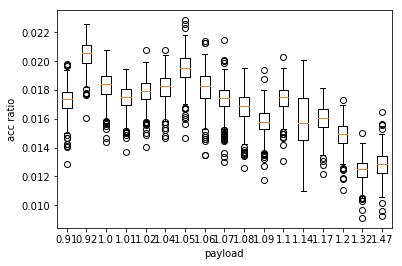

In [795]:
# 速度为1.26条件下的特征随负载变化情况分析
dataPlot0 = []
n = len(dataS126)
for i in range(n):
    dataPlot0.append(dataS126[i]['f_105'] / dataS126[i]['f_110'])
payloadS126 = np.array(payloadS126)
payIdx = payloadS126.argsort()
dataPlot = []
for i in range(n):
    dataPlot.append(dataPlot0[payIdx[i]])
plt.boxplot(dataPlot, labels=payloadS126[payIdx])
plt.xlabel('payload')
plt.ylabel('acc ratio')
plt.show()

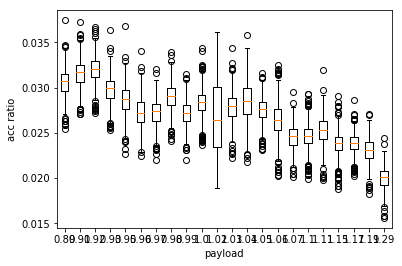

In [794]:
# 速度为1.26条件下的特征随负载变化情况分析
dataPlot0 = []
n = len(dataS102)
for i in range(n):
    dataPlot0.append(dataS102[i]['f_105'] / dataS102[i]['f_110'])
payloadS102 = np.array(payloadS102)
payIdx = payloadS102.argsort()
dataPlot = []
for i in range(n):
    dataPlot.append(dataPlot0[payIdx[i]])
plt.boxplot(dataPlot, labels=payloadS102[payIdx])
plt.xlabel('payload')
plt.ylabel('acc ratio')
plt.show()

## 轨道切分

In [788]:
# 寻找最匹配training试验
nneArr = findNNE(np.array(conditionTraining[['Payload', 'Speed', 'Track']]), np.array(conditionTesting[['Payload', 'Speed', 'Track']]))

In [187]:
# 根据相似度计算最佳切分位置
bestTrim = np.zeros(200)
for i in range(200):
#     bestCorr = 0
    tempArr = np.array(dataTraining[int(nneArr[i])][['f_127', 'f_128', 'f_129', 'f_130']])
    tempTestArr = np.array(dataTesting[i][['f_127', 'f_128', 'f_129', 'f_130']])
    cor = np.zeros([len(tempArr) - 49, 4])
    for j in range(4):
        for t in range(len(tempArr) - 49):
            cor[t, j] = corr(tempArr[t: t+50, j], tempTestArr[:, j])
    corMean = np.mean(cor, 1)
#         if cor > bestCorr:
#     bestCorr = cor
    bestTrim[i] = corMean.argmax()

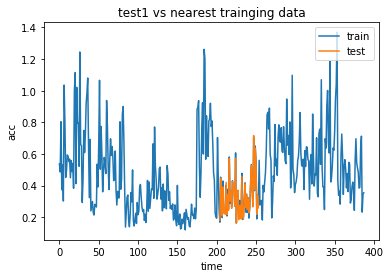

In [787]:
# 切分结果实例：第一组测试试验数据与最匹配的训练集数据的轨道切分结果
plt.plot(np.arange(388), dataTraining[int(nneArr[0])].loc[:, ['f_128']], label= 'train')
plt.plot(np.arange(50) + bestTrim[0], dataTesting[0].loc[:, ['f_128']], label= 'test')
plt.legend()
plt.xlabel('time')
plt.ylabel('acc')
plt.title('test1 vs nearest trainging data')
plt.show()

## 构建训练集并进行机器学习

In [433]:
Track2 = conditionTraining[conditionTraining['Track'] == 2]
# inter1 = Track1[Track1['Speed'] == 0.87 | Track1['Speed'] == 0.94]
# inter1
list1 = list(set(Track2['Payload']))
list2 = []
for i in range(len(list1)):
    if len(set(Track2[Track2['Payload'] == list1[i]]['Speed'])) == 2:
        list2.append(list1[i])
countArr = np.zeros([len(list2), 2])
for i in range(len(list2)):
    countArr[i][0] = sum(Track2[Track2['Payload'] == list2[i]]['Speed'] == 0.87)
    countArr[i][1] = sum(Track2[Track2['Payload'] == list2[i]]['Speed'] == 0.94)

In [754]:
XTrainList = []
loadTraingList = []
for i in range(200):
    speed = conditionTraining['Speed'][int(nneArr[i])]
    trim = bestTrim[i]
    if speed > 0.8:
        XTrain,loadList = buildDataSets(speed=speed, trim=trim)
    else:
        speed = conditionTesting['Speed'][i]
        XTrain = interDataSets(speed=speed, trim=trim)
        loadList = list2
    XTrainList.append(XTrain)
    loadTraingList.append(loadList)

In [755]:
# 训练集、测试集数据处理
fetPos = []
labelTraining = [] #np.zeros([len(XTrain), 155])
loadTraining = [] #np.array(loadTraining).reshape([len(loadTraining), 1])
labelTesting = []
for i in range(200):
    tempArr = np.zeros([len(XTrainList[i]), 155])
    for j in range(len(XTrainList[i])):
        tempArr[j], tmp = fetProcess(XTrainList[i][j])
    labelTraining.append(tempArr)
    loadTraining.append(np.array(loadTraingList[i]).reshape([len(loadTraingList[i]), 1]))
    if i == 0: fetPos = tmp
    tempTest, tmp = fetProcess(dataMedianTesting[i])
    labelTesting.append(tempTest)
loadTesting = np.array(conditionTesting['Payload'])

In [756]:
linregList = []
for i in range(200):
    regList = []
    for j in range(np.shape(labelTraining[i])[1]):
        linreg = LinearRegression()
        linreg.fit(loadTraining[i], labelTraining[i][:, j].reshape([np.shape(labelTraining[i])[0], 1]))
        regList.append(linreg)
    linregList.append(regList)

In [757]:
m = len(loadTesting)
n = len(labelTesting[0])
resArr = np.zeros([m, n])
ratArr = np.zeros([m, n])
resArrB = np.zeros([m, int(n/5)])
ratArrB = np.zeros([m, int(n/5)])
yHat = np.zeros([m, n])
for i in range(m):
    for j in range(n):
        loadLen = len(loadTraining[i])
        tval = stats.t.isf(0.01 / 2, loadLen - 2)
        yHat[i][j] = linregList[i][j].predict(loadTesting[i])
        pstd = np.sqrt(sum((linregList[i][j].predict(loadTraining[i]) - labelTraining[i][:, j].reshape([loadLen, 1])) ** 2) / (loadLen - 2))
        sxx = np.var(loadTraining[i]) * loadLen
        interval = tval * pstd * np.sqrt(1 + 1 / loadLen + (loadTesting[i] - np.mean(loadTraining[i])) ** 2 / sxx)
        resArr[i][j] = abs(yHat[i][j] - labelTesting[i][j]) / interval
        ratArr[i][j] = abs(yHat[i][j] - labelTesting[i][j]) / yHat[i][j]

for i in range(int(n/5)):
    resArrB[:, i] = np.mean(resArr[:, 5*i:5*i+5], 1)
    ratArrB[:, i] = np.mean(ratArr[:, 5*i:5*i+5], 1)

In [800]:
# 所有故障测试
np.arange(200)[resArrB.max(1) > 1]

array([  2,   3,   5,   6,   9,  12,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  25,  26,  28,  30,  31,  32,  33,  34,  35,  36,
        39,  40,  43,  44,  45,  46,  47,  48,  50,  51,  52,  54,  55,
        56,  57,  59,  60,  61,  62,  63,  67,  68,  72,  80,  81,  83,
        86,  87,  91,  92,  94,  95,  96,  98,  99, 101, 104, 105, 106,
       107, 111, 113, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128,
       131, 132, 133, 134, 138, 139, 140, 141, 142, 144, 150, 152, 154,
       156, 157, 160, 161, 162, 165, 167, 169, 170, 171, 173, 174, 175,
       176, 177, 178, 179, 181, 182, 185, 186, 189, 190, 191, 197, 198])

## 定位故障位置

In [810]:
votScore = np.zeros([200, 12])
for i in range(200):
    if np.max(resArrB[i]) > 1:
        for j in range(int(resArrB.shape[1])):
            if resArrB[i][j] > 1:
                votScore[i][fetPos[j]] += resArrB[i][j]
votSortIdx = np.argsort(votScore, 1)
votSort = np.sort(votScore, 1)

In [832]:
canList = []
canIdxList = []
for i in range(200):
    if votSort[i][-1] > 0 and votSort[i][-2] < 50:
        canList.append(votSort[i])
        canIdxList.append(i)

canArr = np.array(canList)
clu_pred = KMeans(n_clusters=2, random_state=0).fit_predict(np.concatenate((canArr[:, -2].reshape([len(canList), 1]), canArr[:, -2].reshape([len(canList), 1])), 1))
clu_pred = list(clu_pred)
for i in range(200):
    if votSort[i][-2] >= 50:
        clu_pred.append(1)
        canIdxList.append(i)

In [833]:
# 两个部件同时发生故障的标志集合
doubleFault = np.zeros(200)
for i in range(len(canIdxList)):
    if clu_pred[i] >= 1:
        doubleFault[int(canIdxList[i])] = 1

## 判断故障部件类型

In [837]:
comFault = np.zeros([200, 2])
for i in range(200):
    if np.max(votSort[i]) > 0:
        if votSortIdx[i][-1] < 4:
            startIdx = (votSortIdx[i][-1] // 2) * 5
            specFault = np.argmax(resArr[i][startIdx: startIdx + 5]) + 1
            if specFault > 3:
                comFault[i][0] = 1
            else:
                comFault[i][0] = 2
        else:
            startIdx = (votSortIdx[i][-1] - 4) * 5 + 40
            specFault = np.argmax(resArr[i][startIdx: startIdx + 5]) + 1
            if specFault == 4:
                comFault[i][0] = 1
            else:
                comFault[i][0] = 2
        if doubleFault[i] == 1:
            if votSortIdx[i][-2] < 4:
                startIdx = (votSortIdx[i][-2] // 2) * 5
                specFault = np.argmax(resArr[i][startIdx: startIdx + 5]) + 1
                if specFault > 3:
                    comFault[i][1] = 1
                else:
                    comFault[i][1] = 2
            else:
                startIdx = (votSortIdx[i][-2] - 4) * 5 + 40
                specFault = np.argmax(resArr[i][startIdx: startIdx + 5]) + 1
                if specFault == 4:
                    comFault[i][1] = 1
                else:
                    comFault[i][1] = 2

In [874]:
# 故障类型对照字典
comFaultDict = {1: 'czp_1r', 2: 'czp_1l', 3: 'czp_2r', 4: 'czp_2l', 5: 'dzp_1r', 6: 'dzp_1l', 7: 'dzp_2r', 8: 'dzp_2l', \
                9: 'czs_1', 10: 'dzs_1r', 11: 'dzs_1l', 12: 'czp_3r', 13: 'czp_3l', 14: 'czp_4r', 15: 'czp_4l', 16: 'dzp_3r', \
                17: 'dzp_3l', 18: 'dzp_4r', 19: 'dzp_4l', 20: 'czs_2', 21: 'dzs_2r', 22: 'dzs_2l'}

In [898]:
# 最终计算结果
result = pd.DataFrame(comFault, index=np.arange(200), columns=['FaultPosition1', 'FaultPosition2'])
for i in range(200):
    result.loc[i]['FaultPosition1'] = 'None'
    result.loc[i]['FaultPosition2'] = 'None'
    if comFault[i][0] == 1:
        if votSortIdx[i][-1] == 0: result.loc[i]['FaultPosition1'] = 10
        if votSortIdx[i][-1] == 1: result.loc[i]['FaultPosition1'] = 11
        if votSortIdx[i][-1] == 2: result.loc[i]['FaultPosition1'] = 21
        if votSortIdx[i][-1] == 3: result.loc[i]['FaultPosition1'] = 22
        if votSortIdx[i][-1] == 4: result.loc[i]['FaultPosition1'] = 5
        if votSortIdx[i][-1] == 5: result.loc[i]['FaultPosition1'] = 6
        if votSortIdx[i][-1] == 6: result.loc[i]['FaultPosition1'] = 7
        if votSortIdx[i][-1] == 7: result.loc[i]['FaultPosition1'] = 8
        if votSortIdx[i][-1] == 8: result.loc[i]['FaultPosition1'] = 16
        if votSortIdx[i][-1] == 9: result.loc[i]['FaultPosition1'] = 17
        if votSortIdx[i][-1] == 10: result.loc[i]['FaultPosition1'] = 18
        if votSortIdx[i][-1] == 11: result.loc[i]['FaultPosition1'] = 19
    else:
        if comFault[i][0] == 2:
            if votSortIdx[i][-1] == 0: result.loc[i]['FaultPosition1'] = 9
            if votSortIdx[i][-1] == 1: result.loc[i]['FaultPosition1'] = 9
            if votSortIdx[i][-1] == 2: result.loc[i]['FaultPosition1'] = 20
            if votSortIdx[i][-1] == 3: result.loc[i]['FaultPosition1'] = 20
            if votSortIdx[i][-1] == 4: result.loc[i]['FaultPosition1'] = 1
            if votSortIdx[i][-1] == 5: result.loc[i]['FaultPosition1'] = 2
            if votSortIdx[i][-1] == 6: result.loc[i]['FaultPosition1'] = 3
            if votSortIdx[i][-1] == 7: result.loc[i]['FaultPosition1'] = 4
            if votSortIdx[i][-1] == 8: result.loc[i]['FaultPosition1'] = 12
            if votSortIdx[i][-1] == 9: result.loc[i]['FaultPosition1'] = 13
            if votSortIdx[i][-1] == 10: result.loc[i]['FaultPosition1'] = 14
            if votSortIdx[i][-1] == 11: result.loc[i]['FaultPosition1'] = 15
    if comFault[i][1] == 1:
        if votSortIdx[i][-1] == 0: result.loc[i]['FaultPosition2'] = 10
        if votSortIdx[i][-1] == 1: result.loc[i]['FaultPosition2'] = 11
        if votSortIdx[i][-1] == 2: result.loc[i]['FaultPosition2'] = 21
        if votSortIdx[i][-1] == 3: result.loc[i]['FaultPosition2'] = 22
        if votSortIdx[i][-1] == 4: result.loc[i]['FaultPosition2'] = 5
        if votSortIdx[i][-1] == 5: result.loc[i]['FaultPosition2'] = 6
        if votSortIdx[i][-1] == 6: result.loc[i]['FaultPosition2'] = 7
        if votSortIdx[i][-1] == 7: result.loc[i]['FaultPosition2'] = 8
        if votSortIdx[i][-1] == 8: result.loc[i]['FaultPosition2'] = 16
        if votSortIdx[i][-1] == 9: result.loc[i]['FaultPosition2'] = 17
        if votSortIdx[i][-1] == 10: result.loc[i]['FaultPosition2'] = 18
        if votSortIdx[i][-1] == 11: result.loc[i]['FaultPosition2'] = 19
    else:
        if comFault[i][1] == 2:
            if votSortIdx[i][-1] == 0: result.loc[i]['FaultPosition2'] = 9
            if votSortIdx[i][-1] == 1: result.loc[i]['FaultPosition2'] = 9
            if votSortIdx[i][-1] == 2: result.loc[i]['FaultPosition2'] = 20
            if votSortIdx[i][-1] == 3: result.loc[i]['FaultPosition2'] = 20
            if votSortIdx[i][-1] == 4: result.loc[i]['FaultPosition2'] = 1
            if votSortIdx[i][-1] == 5: result.loc[i]['FaultPosition2'] = 2
            if votSortIdx[i][-1] == 6: result.loc[i]['FaultPosition2'] = 3
            if votSortIdx[i][-1] == 7: result.loc[i]['FaultPosition2'] = 4
            if votSortIdx[i][-1] == 8: result.loc[i]['FaultPosition2'] = 12
            if votSortIdx[i][-1] == 9: result.loc[i]['FaultPosition2'] = 13
            if votSortIdx[i][-1] == 10: result.loc[i]['FaultPosition2'] = 14
            if votSortIdx[i][-1] == 11: result.loc[i]['FaultPosition2'] = 15

## 故障分类结果可视化

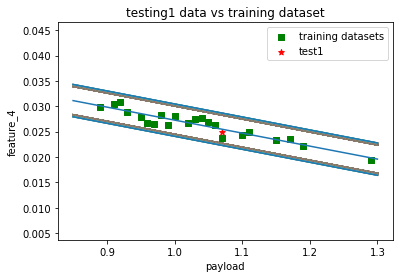

In [784]:
# 故障试验可视化实例：第1次测试集数据与训练集中对应数据的对比
pltx = np.linspace(0.85, 1.3, 100)
plty = linregList[0][4].predict(pltx.reshape([100, 1]))
plty2 = linregList[0][4].predict(loadTraining[0].reshape([len(loadTraining[0]), 1]))
pstd = np.sqrt(sum((plty2 - labelTraining[0][:, 4].reshape([len(loadTraining[0]), 1])) ** 2) / (len(loadTraining[0]) - 2))
sxx = np.var(loadTraining[0]) * len(loadTraining[0])
plt.scatter(loadTraining[0], labelTraining[0][:, 4], marker='s', c='g', label='training datasets')
plt.plot(pltx, plty)
plt.plot(pltx, plty + tval * pstd * np.sqrt(1 + 1/len(loadTraining[0]) + (pltx - np.mean(loadTraining[0])) ** 2 / sxx))
plt.plot(pltx, plty - tval * pstd * np.sqrt(1 + 1/len(loadTraining[0]) + (pltx - np.mean(loadTraining[0])) ** 2 / sxx))
plt.scatter(loadTesting[0], labelTesting[0][4], marker='*',c='r', label='test1')
plt.xlabel('payload')
plt.ylabel('feature_4')
plt.title('testing1 data vs training dataset')
plt.legend()
plt.show()

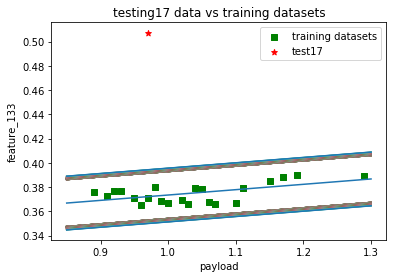

In [783]:
# 故障试验可视化实例：第17次测试集数据与训练集中对应数据的对比
pltx = np.linspace(0.85, 1.3, 100)
plty = linregList[16][133].predict(pltx.reshape([100, 1]))
plty2 = linregList[16][133].predict(loadTraining[16].reshape([len(loadTraining[16]), 1]))
pstd = np.sqrt(sum((plty2 - labelTraining[16][:, 133].reshape([len(loadTraining[16]), 1])) ** 2) / (len(loadTraining[16]) - 2))
sxx = np.var(loadTraining[16]) * len(loadTraining[16])
plt.scatter(loadTraining[16], labelTraining[16][:, 133], marker='s', c='g', label='training datasets')
plt.plot(pltx, plty)
plt.plot(pltx, plty + tval * pstd * np.sqrt(1 + 1/len(loadTraining[16]) + (pltx - np.mean(loadTraining[16])) ** 2 / sxx))
plt.plot(pltx, plty - tval * pstd * np.sqrt(1 + 1/len(loadTraining[16]) + (pltx - np.mean(loadTraining[16])) ** 2 / sxx))
plt.scatter(loadTesting[16], labelTesting[16][133], marker='*',c='r', label='test17')
plt.xlabel('payload')
plt.ylabel('feature_133')
plt.title('testing17 data vs training datasets')
plt.legend()
plt.show()

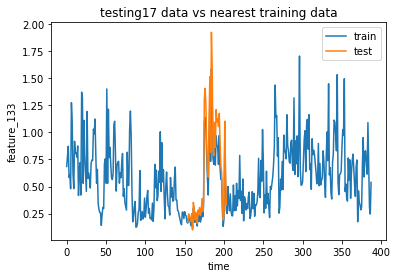

In [782]:
# 故障试验可视化实例：第17次测试集数据与最匹配的训练集中数据的对比
plt.plot(np.arange(388), dataTraining[int(nneArr[16])].loc[:, ['f_123']], label= 'train')
plt.plot(np.arange(50) + bestTrim[16], dataTesting[16].loc[:, ['f_123']], label= 'test')
plt.legend()
plt.xlabel('time')
plt.ylabel('feature_133')
plt.title('testing17 data vs nearest training data')
plt.show()

## 最终结果

In [901]:
result

,FaultPosition1,FaultPosition2
0,0.0,0.0
1,0.0,0.0
2,5.0,0.0
3,7.0,0.0
4,0.0,0.0
5,19.0,19.0
6,19.0,19.0
7,0.0,0.0
8,0.0,0.0
9,8.0,0.0
